This pipeline is used to scrap protein sequences from a list of patents. It then processes them  to remove short and duplicated sequences, and runs multiple sequences alignments to assess similarity. Any above a specific sequence ID threshold are removed. Filtered sequences are then run through another round of MSA, and phylogenetic trees are generated. Outputs are provided as csv and fasta files.

It is currently designed to be run in Google Co-lab, and will not run as a standalone python script. I will fix this at somepoint...

The below code functions as a master script, but the individual models are available as stand-alone code if required.

Module 1 - Importing libraries and connecting google drive

Module 2 - Downloading patent databases
This will prompt the user as to whether or not to download the ebi patent databases from their ftp server, and save them to your google drive. You only need to do this once.

Module 3 - Patent Sequence Seeker
The script inputs a list of patent numbers once stripped of the preceding letters e.g. US, trailing version id (e.g. A1), and all and any punctuation (e.g. 2014/384930), using the cvs_patent_list_reformatter script. It will then search the EU, US, japanese and korean patent databases, grab any sequences from the patent numbers submitted, and save them to your google drive.

Module 4 - Faster combiner
This will take the individual patent fasta files produced from the above, and combine them into a single file.

Module 5 - Patent filter
This will parse the combined file from above, and remove any sequences below a specified length, eg 200 residues. It will also remove any duplicates, and has an input to remove specific sequence identifiers or patents not required. It will print an accurate number for the sequences originally loaded, and those in the final file, but the numbers it gives for the ones removed in each class are unreliable (again, I will fix this at some point).

Module 6 - Similarity filter
This runs a multiple sequence alignment of the filtered sequences from above, and runs a cut off at a specified similarity - the default is set to 95%. It then takes creates a new fasta file with the sequences which are less that 95% similar to each other, and performs the MSA again to confirm they all fall below the cutoff relative to each other.

Module 7 - Tree builder
This runs another MSA on the filtered sequences and builds a phylogenetic tree. It then has the option to split the tree into separate files at a specified number of branch points. For example, entering ‘2’ will split the original fasta file into two new ones at the first branch point (node1_branch1 and node1_branch2), then split each of these in turn to produce node1_branch1_node2_branch1 etc.

Module 8 - blastp (SLOW!)
This will take a fasta file input and run blastp. It will then print the top five hits for each sequence ID, and also save them to a csv, including the ncbi URLs of the hits. This works, but is EXTREMELY slow, ie it takes about 15 minutes per sequence, so not recommended unless you really need to. It does have a function to resume from where it left of if unexpected disconnected though.

Module 9 - NCBI scrapper (beta)
This module takes a list of NCBI links generated by the blastp scrip above, and searches them for particular words, in this case alpha, beta, and gamma. It is very much in beta and only picks up some instances so use with caution.

In [ ]:
# Module 1: Importing libraries

from google.colab import drive
drive.mount('/content/drive')
import os
from glob import glob
import shutil
from Bio import SeqIO
from Bio.Align.Applications import ClustalOmegaCommandline
from Bio.SeqRecord import SeqRecord
from Bio.Seq import Seq
from Bio import pairwise2
from Bio.pairwise2 import format_alignment
import csv
!apt-get install -y clustalo
import subprocess
from Bio import Phylo, SeqIO
import matplotlib.pyplot as plt
from google.colab import files


In [ ]:
# Module 2: Download patent databases

# Define the Google Drive folder to save the downloaded files
google_drive_folder = '/content/drive/MyDrive/patent_databases/'
if not os.path.exists(google_drive_folder):
    os.makedirs(google_drive_folder)

# Ask the user whether to download the patent databases
download_prompt = input("Do you want to download the ebi patent databases? (y/n): ").strip().lower()

if download_prompt == 'y':
    print("Downloading and extracting ebi patent databases...")
    # Download files using wget
    !wget -P {google_drive_folder} ftp://ftp.ebi.ac.uk/pub/databases/fastafiles/patent/*

    # Extract the downloaded files
    !gunzip {google_drive_folder}/*.gz
else:
    print("Skipping download and extraction of patent databases.")



In [ ]:
# Module 3: Patent sequence seeker

def read_patent_numbers():
    patent_numbers = input("Enter patent numbers separated by spaces: ").split()
    return patent_numbers

# Clean up patent numbers to remove non-numerical characters
#def read_and_clean_patent_numbers():
#    patent_numbers = input("Enter patent numbers separated by spaces: ").split()
#    cleaned_patent_numbers = [re.sub(r'\D', '', patent) for patent in patent_numbers]
#    return cleaned_patent_numbers


def extract_sequences(file_path, patent_number):
    command = f"grep -A 100 {patent_number} {file_path}"
    result = subprocess.run(command, shell=True, capture_output=True, text=True)
    if result.returncode == 0:
        lines = result.stdout.split('\n')
        sequence_lines = []
        sequence_started = False
        for line in lines:
            if sequence_started:
                sequence_lines.append(line)
            if patent_number in line and not sequence_started:
                sequence_started = True
                sequence_lines.append(line)
        return '\n'.join(sequence_lines)
    else:
        return None

def preprocess_fasta(input_file, output_file):
    with open(input_file, "r") as input_handle, open(output_file, "w") as output_handle:
        for line in input_handle:
            #output_handle.write(line.replace(" ", "_"))
            #output_handle.write(line.replace(":", "_"))
            modified_line = line.replace(" ", "_").replace(":", "_")
            output_handle.write(modified_line)

def clean_fasta(input_file, output_file):
    filename = os.path.splitext(os.path.basename(input_file))[0]
    first_part_filename = filename.split('_')[0]
    first_part_filename_no_space = first_part_filename.replace(" ", "")
    records_to_keep = {}

    print(f"Search criteria: {first_part_filename_no_space}")

    with open(input_file, "r") as handle:
        for record in SeqIO.parse(handle, "fasta"):
            record_id_no_space = record.id.replace(" ", "")
            print(f"Processing sequence: {record.id}")
            if first_part_filename_no_space in record_id_no_space:
                seq_str = str(record.seq)
                if seq_str not in records_to_keep:
                    records_to_keep[seq_str] = record
            else:
                print(f"Sequence {record.id} does not contain the search criteria and will be skipped.")

    first_part_filename_file = '_'.join(filename.split('_')[0:2])
    clean_folder = os.path.join(google_drive_folder, 'clean_files')
    if not os.path.exists(clean_folder):
        os.makedirs(clean_folder) # (FILE, exist_ok=true)
    output_file = os.path.join(clean_folder, f"{first_part_filename_file}_clean.fasta")
    with open(output_file, "w") as output_handle:
        SeqIO.write(records_to_keep.values(), output_handle, "fasta")

    print(f"Cleaned sequences saved to {output_file}")


# Function to move files to a 'working files' folder
def move_to_working_folder(files):
    working_folder = os.path.join(google_drive_folder, 'working_files')
    if not os.path.exists(working_folder):
        os.makedirs(working_folder)
    for file in files:
        shutil.move(file, os.path.join(working_folder, os.path.basename(file)))

# New function to count patents found in each database
def count_patent_occurrences(patent_numbers, databases):
  """
  Counts the number of patents found in each database.

  Args:
      patent_numbers: A list of cleaned patent numbers.
      databases: A list of database file paths.

  Returns:
      A dictionary where keys are database names and values are counts of patents found.
  """
  patent_counts = {db: 0 for db in databases}
  for patent in patent_numbers:
    for database in databases:
      if extract_sequences(database, patent):
        patent_counts[database] += 1
  return patent_counts

  # Call the new function to count occurrences
  patent_occurrences = count_patent_occurrences(patent_numbers, databases)

  # Print search results for each database
  for database, count in patent_occurrences.items():
    print(f"\nSearching in {database}...")
    if count > 0:
      print(f"{count} patent(s) found!")
    else:
      print("No patents found.")

# Function to move files to a 'clean files' folder
#def move_to_clean_folder(files):
#    clean_folder = os.path.join(google_drive_folder, 'clean_files')
#    if not os.path.exists(clean_folder):
#        os.makedirs(clean_folder)
#    for file in files:
#        shutil.move(file, os.path.join(clean_folder, os.path.basename(file)))

if __name__ == "__main__":
    patent_numbers = read_patent_numbers()
 #   files = [os.path.join(google_drive_folder, f) for f in ["epo", "epoPrt.dat", "jpo", "jpoPrt.dat", "kipo", "kipoPrt.dat", "uspto", "usptoPrt.dat"]]
    files = [os.path.join(google_drive_folder, f) for f in ["epo",  "jpo", "kipo",  "uspto"]]

    # Call the new function to count occurrences
    #patent_occurrences = count_patent_occurrences(patent_numbers, databases)

    # Print search results for each database
    #for database, count in patent_occurrences.items():
    #  print(f"\nSearching in {database}...")
    #  if count > 0:
    #    print(f"{count} patent(s) found!")
    #  else:
    #    print("No patents found.")

    for file in files:
        print(f"\nSearching in {file}...")

        for patent in patent_numbers:
            sequence = extract_sequences(file, patent)
            if sequence:
                print(f"Search and extraction successful for {patent} in {file}")
                fasta_filename = os.path.join(google_drive_folder, f"{patent}_{os.path.basename(file)}.fasta")
                with open(fasta_filename, "w") as f:
                    f.write(f">{patent}\n{sequence}\n")  # Ensure proper FASTA format

                preprocessed_file = f"{patent}_{os.path.basename(file)}_preprocessed.fasta"
                preprocess_fasta(fasta_filename, preprocessed_file)

                clean_fasta_output_file = f"{patent}_{os.path.basename(file)}_clean.fasta"
                clean_fasta(preprocessed_file, clean_fasta_output_file)

                move_to_working_folder([fasta_filename, preprocessed_file])

            else:
                print(f"Patent number {patent} not found in {file}")

# Call the new function to count occurrences
#patent_occurrences = count_patent_occurrences(patent_numbers, databases)

#Print search results for each database
#for database, count in patent_occurrences.items():
#  print(f"\nSearching in {database}...")
#  if count > 0:
#    print(f"{count} patent(s) found!")
#  else:
#    print("No patents found.")

print("It's not finished. It's finished.")


In [ ]:
# Module 4: Combine clean fasta files into single entity

def combine_fasta_files(input_directory, output_file):
    """
    Combine multiple FASTA files into a single FASTA file.

    Parameters:
    input_directory (str): Directory containing the input FASTA files.
    output_file (str): Path to the output combined FASTA file.
    """
    # Get a list of all FASTA files in the input directory
    fasta_files = glob(os.path.join(input_directory, '*.fasta'))

    # Open the output file for writing
    with open(output_file, 'w') as outfile:
        for fasta_file in fasta_files:
            with open(fasta_file, 'r') as infile:
                # Write the content of the current FASTA file to the output file
                for line in infile:
                    outfile.write(line)

# Define the input directory and output file paths in Google Drive
input_directory = "/content/drive/MyDrive/patent_databases/clean_files/"  # Change to your input directory
output_file = "/content/drive/My Drive/patent_databases/clean_files/combined.fasta"  # Change to your desired output file path

# Combine FASTA files
combine_fasta_files(input_directory, output_file)
print(f"Combined FASTA file written to {output_file}")


In [ ]:
# Module 5a - Filter sequences by legnth, duplicates, and specific text inputs - definitions
# Define subroutines

def parse_fasta(output_file):
    sequences = {}
    with open(input_file, 'r') as f:
        current_id = None
        current_seq = ''
        for line in f:
            line = line.strip()
            if line.startswith('>'):
                if current_id is not None:
                    sequences[current_id] = current_seq
                current_id = line[1:]
                current_seq = ''
            else:
                current_seq += line
        if current_id is not None:
            sequences[current_id] = current_seq
    return sequences

# Run filters: Length, custom text, duplicatets
def filter_sequences(sequences, min_length=100, remove_texts=None):
    original_count = len(sequences)
    filtered_sequences = {}
    removed_duplicates = []
    removed_length = []
    unique_patent_sequence_names = set()
    for seq_id, seq in sequences.items():
        if remove_texts and any(text in seq_id for text in remove_texts):
            continue  # Skip sequences containing any of the specified texts
        if len(seq) >= min_length:
            is_duplicate = False
            for other_id, other_seq in sequences.items():
                if seq_id != other_id and seq in other_seq:
                    is_duplicate = True
                    removed_duplicates.append(seq_id)
                    break
            if not is_duplicate:
                filtered_sequences[seq_id] = seq
                if "patent" in seq_id:
                    _, seq_name = seq_id.split("patent", 1)
                    unique_patent_sequence_names.add(seq_name.strip())
                if "Patent" in seq_id:
                    _, seq_name = seq_id.split("Patent", 1)
                    unique_patent_sequence_names.add(seq_name.strip())
            else:
                removed_length.append(seq_id)
    remaining_count = len(filtered_sequences)
    removed_duplicates_count = len(removed_duplicates)
    removed_length_count = len(removed_length)
    return filtered_sequences, removed_duplicates_count, removed_length_count, remaining_count, original_count, unique_patent_sequence_names

# Write output fasta and csv files

def write_fasta(output_file, sequences):
    with open(output_file, 'w') as f:
        for seq_id, seq in sequences.items():
            f.write(f'>{seq_id}\n')
            f.write(f'{seq}\n')

def write_csv(output_file, sequences):
    with open(output_file, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(["Sequence ID", "Sequence"])
        for seq_id, seq in sequences.items():
            writer.writerow([seq_id, seq])

import os
import csv

# Assuming parse_fasta and filter_sequences functions are already defined elsewhere

def remove_duplicate_strings(header):
    parts = header.split('_')
    seen = set()
    new_parts = []
    for part in parts:
        if part not in seen:
            seen.add(part)
            new_parts.append(part)
    return '_'.join(new_parts)

def filter_and_save(input_file, remove_texts=None):
    sequences = parse_fasta(input_file)

    # Plot histogram before filtering
    plot_histogram(sequences, 'Histogram of Sequence Lengths Before Filtering')

    filtered_sequences, removed_duplicates_count, removed_length_count, remaining_count, original_count, unique_patent_sequence_names = filter_sequences(sequences, remove_texts=remove_texts)

    # Plot histogram after filtering
    plot_histogram(filtered_sequences, 'Histogram of Sequence Lengths After Filtering')

    output_file_base = os.path.splitext(input_file)[0]
    fasta_output_file = f"{output_file_base}_filtered.fasta"
    csv_output_file = f"{output_file_base}_filtered.csv"

    # Replace colons in sequence IDs with underscores and remove duplicate strings
    filtered_sequences = {remove_duplicate_strings(seq_id.replace(':', '_')): seq for seq_id, seq in filtered_sequences.items()}

    write_fasta(fasta_output_file, filtered_sequences)
    write_csv(csv_output_file, filtered_sequences)

    return original_count, removed_duplicates_count, removed_length_count, remaining_count, unique_patent_sequence_names


def plot_histogram(sequences, title):
    lengths = [len(seq) for seq in sequences.values()]
    plt.hist(lengths, bins=range(0, max(lengths) + 20, 20), edgecolor='black')
    plt.title(title)
    plt.xlabel('Sequence Length')
    plt.ylabel('Frequency')
    plt.show()



Enter space-separated list of texts to remove from sequence IDs (leave blank if none): AYI49036 AYI49033 AYI49035 AYI49031 AYI49034 AYI49030


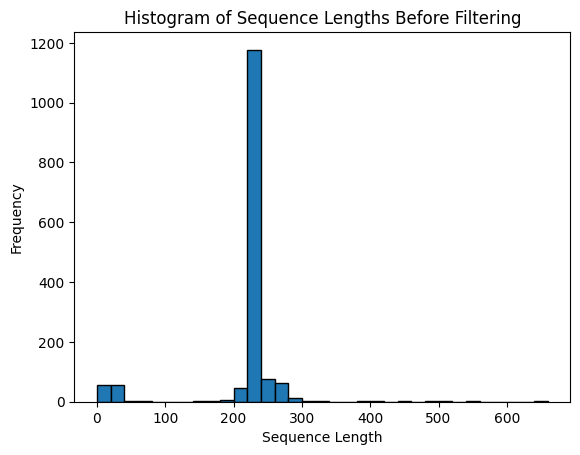

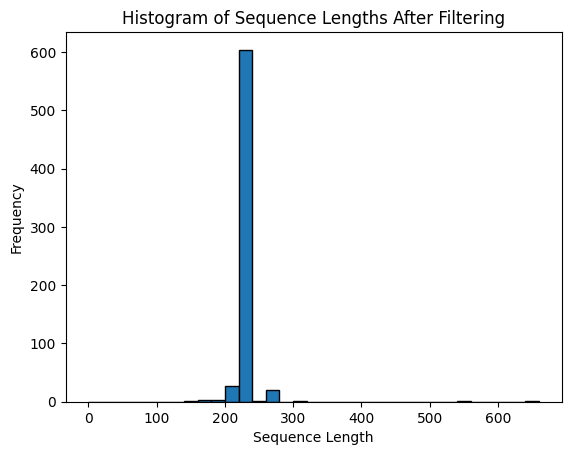

Number of original sequences: 1522
Number removed based on identical sequences: 735
Number removed based on length: 735
Number remaining: 666
List of unique patent numbers:
_EP2385982.
Patent: _EP2385982. - URL: https://patents.google.com/?q=_EP2385982.
_US_8354262.
Patent: _US_8354262. - URL: https://patents.google.com/?q=_US_8354262.
_US_7521217.
Patent: _US_7521217. - URL: https://patents.google.com/?q=_US_7521217.
_US_5912333.
Patent: _US_5912333. - URL: https://patents.google.com/?q=_US_5912333.
_US_10053702.
Patent: _US_10053702. - URL: https://patents.google.com/?q=_US_10053702.
_WO2014090327.
Patent: _WO2014090327. - URL: https://patents.google.com/?q=_WO2014090327.
_US_9540625.
Patent: _US_9540625. - URL: https://patents.google.com/?q=_US_9540625.
_US_10920213.
Patent: _US_10920213. - URL: https://patents.google.com/?q=_US_10920213.


In [ ]:
# Module 5b - Filter sequences by legnth, duplicates, and specific text inputs - Main code
from google.colab import files
if __name__ == "__main__":
    #uploaded = files.upload()
    #input_file = list(uploaded.keys())[0]  # Use the first uploaded file
    #input_file = output_file
    input_file = "/content/drive/MyDrive/patent_databases/clean_files/combined.fasta"
    #output_file = "filtered.fasta"
    remove_texts_input = input("Enter space-separated list of texts to remove from sequence IDs (leave blank if none): ").split(' ')
    #remove_texts_input = ""
    remove_texts = [text.strip() for text in remove_texts_input if text.strip()]

    original_count, removed_duplicates_count, removed_length_count, remaining_count, unique_patent_sequence_names = filter_and_save(input_file, remove_texts)

    output_file_base = os.path.splitext(input_file)[0]
    fasta_output_file = f"{output_file_base}_filtered.fasta"

    # Print results and URLs
    print("Number of original sequences:", original_count)
    print("Number removed based on identical sequences:", removed_duplicates_count)
    print("Number removed based on length:", removed_length_count)
    print("Number remaining:", remaining_count)
    print("List of unique patent numbers:")
    for patent_number in unique_patent_sequence_names:
        print(patent_number.replace(' ', ''))
        patent_url = f"https://patents.google.com/?q={patent_number.replace(' ', '')}"
        print(f"Patent: {patent_number} - URL: {patent_url}")


In [ ]:
# Module 6 - Similarity filter with gap remover

# Function to filter sequences in a single file
def filter_sequences_in_file(input_file, threshold=95):
    sequences = [record for record in SeqIO.parse(input_file, "fasta") if len(record.seq) > 0]

    if not sequences:
        raise ValueError("No valid sequences found in the input file.")

    # Write sequences to a temporary file for MSA
    temp_input_file = "temp.fasta"
    SeqIO.write(sequences, temp_input_file, "fasta")

    # Perform Clustal Omega alignment
    clustal_output = "aligned.aln"
    clustalomega_cline = ClustalOmegaCommandline(infile=temp_input_file, outfile=clustal_output, verbose=True, auto=True, force=True)
    stdout, stderr = clustalomega_cline()

    # Read the aligned sequences
    aligned_sequences = list(SeqIO.parse(clustal_output, "fasta"))

    # Filter sequences based on similarity
    filtered_sequences = []
    for record in aligned_sequences:
        is_unique = True
        for filtered_record in filtered_sequences:
            similarity = sum(a == b for a, b in zip(record.seq, filtered_record.seq)) / min(len(record.seq), len(filtered_record.seq))
            if similarity >= threshold / 100:
                is_unique = False
                break
        if is_unique:
            filtered_sequences.append(record)

    # Write filtered sequences to a new FASTA file
    input_base_name = os.path.splitext(os.path.basename(input_file))[0]
    filtered_file = f"{input_base_name}_filtered_{threshold}.fasta"
    SeqIO.write(filtered_sequences, filtered_file, "fasta")
    return filtered_file, sequences, aligned_sequences, filtered_sequences

# Function to remove gaps from sequences
def remove_gaps_from_sequences(input_file, output_file):
    sequences = SeqIO.parse(input_file, "fasta")
    cleaned_sequences = []

    for record in sequences:
        record.seq = record.seq.replace("-", "")
        cleaned_sequences.append(record)

    with open(output_file, "w") as output_handle:
        SeqIO.write(cleaned_sequences, output_handle, "fasta")

if __name__ == "__main__":
    # Step 1: Upload a FASTA file
    uploaded = files.upload()
    input_file = list(uploaded.keys())[0]  # Use the first uploaded file

    #for input_file in new_files:
    #input_file = fasta_output_file #from main filter above

    # Step 2: Apply the similarity filter
    filtered_file, original_sequences, aligned_sequences, filtered_sequences = filter_sequences_in_file(input_file)

    # Step 3: Remove gaps from the filtered sequences and save to a new FASTA file
    output_file = os.path.splitext(filtered_file)[0] + "_cleaned.fasta"
    remove_gaps_from_sequences(filtered_file, output_file)

    # Print original files with similarity percentages
    print(f"Original sequences in {input_file} with similarity % to their closest match:")
    for record in aligned_sequences:
        closest_similarity = 0
        for other_record in aligned_sequences:
            if record.id != other_record.id:
                similarity = sum(a == b for a, b in zip(record.seq, other_record.seq)) / min(len(record.seq), len(other_record.seq)) * 100
                if similarity > closest_similarity:
                    closest_similarity = similarity
        print(f"{record.id}: {closest_similarity:.2f}%")

    # Print filtered sequences with similarity percentages
    print(f"\nFiltered sequences in {filtered_file} with similarity % to their closest match in the filtered list:")
    for record in filtered_sequences:
        closest_similarity = 0
        for other_record in filtered_sequences:
            if record.id != other_record.id:
                similarity = sum(a == b for a, b in zip(record.seq, other_record.seq)) / min(len(record.seq), len(other_record.seq)) * 100
                if similarity > closest_similarity:
                    closest_similarity = similarity
        print(f"{record.id}: {closest_similarity:.2f}%")

print(f"\nNumber of input sequences: {len(original_sequences)}")
print(f"Number of output sequences: {len(filtered_sequences)}")
print("")
print(f"\nFiltered and cleaned sequences saved to: {output_file} from input file: {input_file}")


In [ ]:
import os
import matplotlib.pyplot as plt
from Bio import SeqIO
from Bio.Align.Applications import ClustalOmegaCommandline
from google.colab import files

# Function to filter sequences in a single file
def filter_sequences_in_file(input_file, threshold=95):
    sequences = [record for record in SeqIO.parse(input_file, "fasta") if len(record.seq) > 0]

    if not sequences:
        raise ValueError("No valid sequences found in the input file.")

    # Write sequences to a temporary file for MSA
    temp_input_file = "temp.fasta"
    SeqIO.write(sequences, temp_input_file, "fasta")

    # Perform Clustal Omega alignment
    clustal_output = "aligned.aln"
    clustalomega_cline = ClustalOmegaCommandline(infile=temp_input_file, outfile=clustal_output, verbose=True, auto=True, force=True)
    stdout, stderr = clustalomega_cline()

    # Read the aligned sequences
    aligned_sequences = list(SeqIO.parse(clustal_output, "fasta"))

    # Filter sequences based on similarity
    filtered_sequences = []
    removed_sequences = []
    for record in aligned_sequences:
        is_unique = True
        for filtered_record in filtered_sequences:
            similarity = sum(a == b for a, b in zip(record.seq, filtered_record.seq)) / min(len(record.seq), len(filtered_record.seq))
            if similarity >= threshold / 100:
                is_unique = False
                removed_sequences.append(record)
                break
        if is_unique:
            filtered_sequences.append(record)

    # Write filtered sequences to a new FASTA file
    input_base_name = os.path.splitext(os.path.basename(input_file))[0]
    filtered_file = f"{input_base_name}_filtered_{threshold}.fasta"
    SeqIO.write(filtered_sequences, filtered_file, "fasta")
    return filtered_file, sequences, aligned_sequences, filtered_sequences, removed_sequences

# Function to remove gaps from sequences
def remove_gaps_from_sequences(input_file, output_file):
    sequences = SeqIO.parse(input_file, "fasta")
    cleaned_sequences = []

    for record in sequences:
        record.seq = record.seq.replace("-", "")
        cleaned_sequences.append(record)

    with open(output_file, "w") as output_handle:
        SeqIO.write(cleaned_sequences, output_handle, "fasta")

if __name__ == "__main__":
    # Step 1: Upload a FASTA file
    uploaded = files.upload()
    input_file = list(uploaded.keys())[0]  # Use the first uploaded file

    # Step 2: Apply the similarity filter
    filtered_file, original_sequences, aligned_sequences, filtered_sequences, removed_sequences = filter_sequences_in_file(input_file)

    # Step 3: Remove gaps from the filtered sequences and save to a new FASTA file
    output_file = os.path.splitext(filtered_file)[0] + "_cleaned.fasta"
    remove_gaps_from_sequences(filtered_file, output_file)

    # Calculate and print similarity percentages
    def calculate_similarity_percentages(sequences):
        similarities = []
        for i, record in enumerate(sequences):
            closest_similarity = 0
            for j, other_record in enumerate(sequences):
                if i != j:
                    similarity = sum(a == b for a, b in zip(record.seq, other_record.seq)) / min(len(record.seq), len(other_record.seq)) * 100
                    if similarity > closest_similarity:
                        closest_similarity = similarity
            similarities.append(closest_similarity)
        return similarities

    original_similarities = calculate_similarity_percentages(aligned_sequences)
    filtered_similarities = calculate_similarity_percentages(filtered_sequences)

    # Print original sequences with similarity percentages
    print(f"Original sequences in {input_file} with similarity % to their closest match:")
    for record, similarity in zip(aligned_sequences, original_similarities):
        print(f"{record.id}: {similarity:.2f}%")

    # Print filtered sequences with similarity percentages
    print(f"\nFiltered sequences in {filtered_file} with similarity % to their closest match in the filtered list:")
    for record, similarity in zip(filtered_sequences, filtered_similarities):
        print(f"{record.id}: {similarity:.2f}%")

    # Print removed sequences
    print(f"\nRemoved sequences from the filtered list:")
    for record in removed_sequences:
        print(f"{record.id}")

    # Plot histograms of similarity percentages
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.hist(original_similarities, bins=20, color='blue', alpha=0.7)
    plt.title('Original Sequences Similarity')
    plt.xlabel('Similarity %')
    plt.ylabel('Frequency')

    plt.subplot(1, 2, 2)
    plt.hist(filtered_similarities, bins=20, color='green', alpha=0.7)
    plt.title('Filtered Sequences Similarity')
    plt.xlabel('Similarity %')
    plt.ylabel('Frequency')

    plt.tight_layout()
    plt.show()

    print(f"\nNumber of input sequences: {len(original_sequences)}")
    print(f"Number of output sequences: {len(filtered_sequences)}")
    print("")
    print(f"\nFiltered and cleaned sequences saved to: {output_file} from input file: {input_file}")


In [ ]:
# Modeule 7 - Current - with colours, still a bit buggy

# Function to extract and split sequence identifiers
#def extract_sequence_identifiers(tree_file):
#    tree = Phylo.read(tree_file, "newick")
#    modified_names = {}
#    for leaf in tree.get_terminals():
#        parts = leaf.name.split('_')
#        if len(parts) > 2:
#            new_name = f"{parts[1]}_{parts[-1]}"
#            modified_names[leaf.name] = new_name
#            leaf.name = new_name
#        else:
#            modified_names[leaf.name] = leaf.name
#    return modified_names


# Function to extract sequence identifiers
def extract_sequence_identifiers(tree_file):
    tree = Phylo.read(tree_file, "newick")
    return [leaf.name for leaf in tree.get_terminals()]

# Function to parse the Newick tree to obtain the first branch point
def extract_first_branch_point(tree):
    for node in tree.find_clades(order='level'):
        if not node.is_terminal() and len(node.clades) == 2:  # Assuming binary tree
            return node
    return None

# Function to split the tree into clusters at the first branch point
def split_tree_into_clusters(tree, branch_point):
    clusters = {}
    for i, child in enumerate(branch_point.clades):
        cluster_name = f"branch{i + 1}"
        clusters[cluster_name] = [leaf.name for leaf in child.get_terminals()]
    return clusters

# Function to write sequences of each cluster into new FASTA files
def write_fasta_file(cluster, cluster_name, original_sequences):
    with open(f"{cluster_name}.fasta", 'w') as f:
        for seq_id in cluster:
            seq_record = original_sequences[seq_id]
            SeqIO.write(seq_record, f, "fasta")

# Function to convert matplotlib color to hex
def rgb_to_hex(color):
    return "#{:02x}{:02x}{:02x}".format(int(color[0]*255), int(color[1]*255), int(color[2]*255))

# Function to draw the tree with color-coded clusters
def draw_tree(tree_file, num_sequences, clusters=None):
    fig_width = 25  # Increased width to fit all text
    fig_height = max(10, num_sequences * 0.15)  # Adjust the height dynamically
    fig = plt.figure(figsize=(fig_width, fig_height))  # Adjust the figure size to ensure identifiers do not overlap
    ax = fig.add_subplot(1, 1, 1)
    tree = Phylo.read(tree_file, "newick")

#    # Modify sequence IDs before drawing
#    original_to_new_names = {}
#    for leaf in tree.get_terminals():
#        parts = leaf.name.split('_')
#        if len(parts) > 2:
#            new_name = f"{parts[1]}_{parts[-1]}"
#            original_to_new_names[leaf.name] = new_name
#            leaf.name = new_name
#        else:
#            original_to_new_names[leaf.name] = leaf.name

    if clusters:
        # Update clusters with new sequence IDs
        updated_clusters = {}
        for cluster_name, seq_ids in clusters.items():
            updated_seq_ids = [original_to_new_names[seq_id] for seq_id in seq_ids]
            updated_clusters[cluster_name] = updated_seq_ids

        # Color code clusters
        colors = plt.get_cmap('tab10')
        for i, (cluster_name, seq_ids) in enumerate(updated_clusters.items()):
            color = rgb_to_hex(colors(i % 10))
            for leaf in tree.get_terminals():
                if leaf.name in seq_ids:
                    leaf.color = color

    Phylo.draw(tree, do_show=False, axes=ax)
    plt.tight_layout()
    plt.show()


# Step 1: Upload a multipart FASTA protein file
uploaded = files.upload()
uploaded_files = list(uploaded.keys())

#uploaded = output_file # from similarity filter above

# Convert uploaded files to list
#uploaded_files = list(uploaded)



# Function to run Clustal Omega for alignment and tree generation
def run_clustalo(fasta_file, iteration):
    iteration_str = f"_iter{iteration}" if iteration >= 1 else ""  # Append iteration number only if it's not the first iteration
    alignment_file = f"{os.path.splitext(fasta_file)[0]}{iteration_str}.aln"
    tree_file = f"{os.path.splitext(fasta_file)[0]}{iteration_str}.dnd"
    subprocess.run(["clustalo", "-i", fasta_file, "-o", alignment_file])
    subprocess.run(["clustalo", "--guidetree-out", tree_file, "-i", alignment_file])
    print(f"Iteration {iteration}: Alignment file - {alignment_file}, Tree file - {tree_file}")  # Add this line for debugging
    print("")  # Add this line for debugging

    return alignment_file, tree_file



# Prompt the user for the number of iterations
num_iterations = int(input("Enter the number of branch points to split the tree: "))

# Process each uploaded file
for file_name in uploaded_files:
    original_sequences = SeqIO.to_dict(SeqIO.parse(file_name, "fasta"))
    current_files = [file_name]
    clusters_overall = {}
    original_to_new_names = {}  # Define the dictionary here

    # Iterate through each iteration
    for iteration in range(num_iterations):
        new_files = []

        # Iterate through files for the current iteration
        for current_file_iter in current_files:
            # Step 2: Run sequences through Clustal Omega for multiple sequence alignment
            alignment_file, tree_file = run_clustalo(current_file_iter, iteration)

            # Step 3: Check if the tree file is created
            if not os.path.isfile(tree_file):
                print(f"Tree file {tree_file} not found. Skipping.")
                continue

            # Step 4: Build and draw a Newick tree from the alignment
            tree = Phylo.read(tree_file, "newick")
            if iteration == 0:
                draw_tree(tree_file, len(tree.get_terminals()))

            # Step 5: Extract the first branch point
            branch_point = extract_first_branch_point(tree)
            if not branch_point:
                print(f"No valid branch point found in iteration {iteration + 1} for file {current_file_iter}")
                continue

            # Step 6: Split the tree into clusters at the branch point
            clusters = split_tree_into_clusters(tree, branch_point)

            # Update the overall clusters dictionary with new sequence IDs
            for cluster_name, cluster in clusters.items():
                # Filter out sequence IDs that do not have a corresponding entry in original_to_new_names
                valid_seq_ids = [seq_id for seq_id in cluster if seq_id in original_to_new_names]
                clusters_overall[f"{os.path.splitext(current_file_iter)[0]}_node{iteration+1}_{cluster_name}"] = [
                    original_to_new_names[seq_id] for seq_id in valid_seq_ids
                ]


            # Step 7: Write sequences of each cluster into new FASTA files
            for cluster_name, cluster in clusters.items():
                new_fasta_file = f"{os.path.splitext(current_file_iter)[0]}_node{iteration+1}_{cluster_name}"
                write_fasta_file(cluster, new_fasta_file, original_sequences)
                new_files.append(new_fasta_file + ".fasta")

        # Update the list of files for the next iteration
        current_files = new_files

        # Draw the new trees for each new file
        for new_file in new_files:
            alignment_file, tree_file = run_clustalo(new_file, iteration + 1)
            if os.path.isfile(tree_file):
                draw_tree(tree_file, len(extract_sequence_identifiers(tree_file)))

    # Draw the final tree with clusters color-coded
    original_tree_file = run_clustalo(file_name, 0)[1]
    if os.path.isfile(original_tree_file):
        draw_tree(original_tree_file, len(extract_sequence_identifiers(original_tree_file)), clusters_overall)

    print(f"Processed file: {file_name}")


In [ ]:
# Module 8 - Blastp SLOW!!

from Bio.Blast import NCBIWWW, NCBIXML
import csv
import requests
from time import sleep
from xml.etree import ElementTree as ET

uploaded = files.upload()

fasta_file = list(uploaded.keys())[0]

# Function to perform BLASTP search and store top 5 hits
def blastp_and_store_hits(seq_record, csv_writer):
    query_id = seq_record.id
    print("Query ID:", query_id)
    result_handle = NCBIWWW.qblast("blastp", "nr", seq_record.seq)
    blast_records = NCBIXML.parse(result_handle)
    for i, blast_record in enumerate(blast_records):
        if i >= 5:  # Limit to top 5 hits
            break
        for alignment in blast_record.alignments[:5]:
            hit_id = alignment.hit_id.split("|")[1]  # Extract NCBI ID
            hit_description = aliågnment.title
            hit_link = f"https://www.ncbi.nlm.nih.gov/protein/{hit_id}"
            csv_writer.writerow([query_id, hit_description, hit_link])
            print("   Hit:", hit_description)
    result_handle.close()

# Function to read the last processed query ID from the CSV file
def get_last_processed_query_id():
    try:
        with open("blast_results.csv", "r", newline="") as csv_file:
            csv_reader = csv.reader(csv_file)
            last_row = None
            for row in csv_reader:
                last_row = row
            if last_row:
                return last_row[0]  # Return the query ID from the last row
    except FileNotFoundError:
        pass  # If the file doesn't exist yet, return None
    return None

# Upload protein FASTA file
from google.colab import files
uploaded = files.upload()

# Open a CSV file for writing or appending
with open("blast_results.csv", "a", newline="") as csv_file:
    csv_writer = csv.writer(csv_file)

    # If the file is empty, write the header row
    if csv_file.tell() == 0:
        csv_writer.writerow(["Query ID", "Hit Description", "NCBI Link"])

    # Get the last processed query ID
    last_processed_query_id = get_last_processed_query_id()

    # Iterate over each sequence in the uploaded FASTA file
    for filename in uploaded.keys():
        with open(filename, "r") as fasta_file:
            for seq_record in SeqIO.parse(fasta_file, "fasta"):
                if last_processed_query_id is not None:
                    # Skip sequences until the last processed query ID is found
                    if seq_record.id != last_processed_query_id:
                        continue
                    # Reset last_processed_query_id after resuming
                    last_processed_query_id = None
                blastp_and_store_hits(seq_record, csv_writer)


In [ ]:
# Module 9 - NCBI scrapper

import requests
import re

# List of URLs to search
urls = [
    "https://www.ncbi.nlm.nih.gov/protein/1QRL",
    "https://www.ncbi.nlm.nih.gov/protein/HKI82391.1",
    "https://www.ncbi.nlm.nih.gov/protein/HIP29611.1",
    "https://www.ncbi.nlm.nih.gov/protein/WP_018153337.1",
    "https://www.ncbi.nlm.nih.gov/protein/MDK2849247.1",
    "https://www.ncbi.nlm.nih.gov/protein/MDK2790423.1",
    "https://www.ncbi.nlm.nih.gov/protein/WP_015898908.1",
    "https://www.ncbi.nlm.nih.gov/protein/XP_006585949.1",
    "https://www.ncbi.nlm.nih.gov/protein/XP_028212979.1",
    "https://www.ncbi.nlm.nih.gov/protein/NP_001328574.1",
    "https://www.ncbi.nlm.nih.gov/protein/2FOQ",
    "https://www.ncbi.nlm.nih.gov/protein/AAA86945.1",
    "https://www.ncbi.nlm.nih.gov/protein/AAA86944.1",
    "https://www.ncbi.nlm.nih.gov/protein/BAF05590.1",
    "https://www.ncbi.nlm.nih.gov/protein/WP_190245347.1",
    "https://www.ncbi.nlm.nih.gov/protein/WP_003688976.1",
    "https://www.ncbi.nlm.nih.gov/protein/AAZ83743.1",
    "https://www.ncbi.nlm.nih.gov/protein/NP_990648.1"
]

# Function to search for words in a webpage
def search_words(url):
    try:
        response = requests.get(url)
        response.raise_for_status()  # Raise an exception for HTTP errors
        html_content = response.text
        # Refine the regular expression pattern to capture all occurrences of the words
        matches = re.findall(r'\b(?:alpha|beta|gamma)\b|\w*(?:alpha|beta|gamma)\w*|\b(?:alpha|beta|gamma)\b(?=[^>]*<)', html_content, flags=re.IGNORECASE)
        return matches
    except Exception as e:
        return str(e)

# Loop through each URL and search for words
for url in urls:
    print("Searching", url)
    matches = search_words(url)
    if isinstance(matches, list):
        if matches:
            print("Matches found:", matches)
        else:
            print("No matches found")
    else:
        print("Error occurred:", matches)
    print("="*50)  # Separator for readability
